### paper plots

pretty plots for final paper

In [2]:
import autoencodeSVJ.utils as utils
import autoencodeSVJ.evaluate as ev

Using TensorFlow backend.


In [3]:
top = utils.summary().cfilter(['*auc*', 'target_dim', 'filename', 'signal_path', 'batch*', 'learning_rate']).sort_values('mae_auc')[::-1].head(10)
top

,batch_size,filename,learning_rate,mae_auc,mse_auc,signal_path,target_dim
96,32,hlf_eflow3_7_v159,0.00146312,0.902315,0.900523,data/all_signals/3000GeV_0.30/base_3/*.h5,7
179,32,hlf_eflow3_7_v38,0.000910648,0.897851,0.891363,data/all_signals/3000GeV_0.30/base_3/*.h5,7
255,64,hlf_eflow3_9_v10,0.0005,0.894303,0.89324,data/all_signals/1500GeV_0.15/base_3/*.h5,9
23,64,hlf_eflow3_6_v3,0.0005,0.890441,0.889744,data/all_signals/2000GeV_0.30/base_3/*.h5,6
136,32,hlf_eflow3_7_v195,0.000838053,0.884811,0.884847,data/all_signals/3000GeV_0.30/base_3/*.h5,7
87,32,hlf_eflow3_7_v150,0.003303,0.882353,0.88152,data/all_signals/3000GeV_0.30/base_3/*.h5,7
139,32,hlf_eflow3_7_v198,0.00251508,0.881822,0.880606,data/all_signals/3000GeV_0.30/base_3/*.h5,7
86,32,hlf_eflow3_7_v15,0.000251868,0.881179,0.88605,data/all_signals/3000GeV_0.30/base_3/*.h5,7
44,32,hlf_eflow3_7_v111,0.000249307,0.880655,0.876243,data/all_signals/3000GeV_0.30/base_3/*.h5,7
53,32,hlf_eflow3_7_v12,0.000662266,0.880288,0.88518,data/all_signals/3000GeV_0.30/base_3/*.h5,7


In [139]:
import os
import autoencodeSVJ.trainer as trainer
import time

class auc_getter(object):
    '''This object basically needs to be able to load a training run into memory, including all 
    training/testing fractions and random seeds. It then should take a library of signals as input
    and be able to evaluate the auc on each signal to determine a 'general auc' for all signals. 
    '''
    def __init__(
        self,
        filename,
        qcd_path=None,
        times=False
    ):
        self.times = times
        self.start()
        self.name = utils.summary_by_name(filename)
        self.d = utils.load_summary(self.name)
        
        self.norm_args = {
            "norm_type": str(self.d["norm_type"])
        }
        
        if qcd_path is None:
            if 'qcd_path' in self.d:
                qcd_path = self.d['qcd_path']
            else:
                raise AttributeError("No QCD path found; please specify!")

        self.qcd_path = qcd_path
                
        self.hlf = self.d['hlf']
        self.eflow = self.d['eflow']
        self.eflow_base = self.d['eflow_base']
        self.hlf_to_drop = map(str, self.d['hlf_to_drop'])

        # get and set random seed for reproductions
        self.seed = self.d['seed']

        # manually set a bunch of parameters from the summary dict
        for param in ['target_dim', 'input_dim', 'test_split', 'val_split', 'filename', 'filepath']:
            setattr(self, param, self.d[param])

        if not os.path.exists(self.filepath + ".pkl"):
            print self.filepath + ".pkl"
            self.filepath = utils.path_in_repo(self.filepath + ".pkl")
            print self.filepath
            if self.filepath is None:
                raise AttributeError("filepath does not exist with spec {}".format(self.d['filepath']))
            else:
                if self.filepath.endswith(".h5"):
                    self.filepath.rstrip(".h5")
                
        self.instance = trainer.trainer(self.filepath)
        self.time('init')
        
    def start(
        self,
    ):
        self.__TIME = time.time()
        
    def time(
        self,
        info=None,
    ):
        end = time.time() - self.__TIME
        if self.times:
            print(':: TIME: ' + '{}executed in {:.2f} s'.format('' if info is None else info + ' ', end))
        return end
    
    def get_test_dataset(
        self,
        data,
        test_key='qcd'
    ):
        self.start()
        assert hasattr(d, test_key), 'please pass a data_holder object instance with attribute \'{}\''.format(test_key)
    
        utils.set_random_seed(self.seed)
        
        qcd = getattr(d, test_key).data
        train, test = qcd.split_by_event(test_fraction=self.test_split, random_state=self.seed, n_skip=2)
        self.time('test dataset')
        return test
    
    def get_errs_recon(
        self,
        data,
        test_key='qcd'
    ):
        test = self.get_test_dataset(data, test_key)
        self.start()
        normed = {d: test.norm(getattr(data, d).data, **self.norm_args) for d in data.KEYS if d != test_key}
        normed[test_key] = test.norm(test, **self.norm_args)
        for key in normed:
            normed[key].name = key + ' norm'
        self.ae = self.instance.load_model()
        normed = normed.values()
        err, recon = utils.get_recon_errors(normed, self.ae)
        self.time('recon gen')
        return normed, err, recon
        
a = auc_getter('hlf_eflow3_7_v198', times=True)
norm, err, recon = a.get_errs_recon(d)

found 1 matches with search '/afs/cern.ch/work/l/llepotti/private/CMS/CMSSW_8_0_20/src/autoencodeSVJ/autoencode/data/summary/hlf_eflow3_7_v198.summary'
:: TIME: init executed in 0.29 s
:: TIME: test dataset executed in 0.16 s
train_shell :: using saved model
:: TIME: recon gen executed in 7.50 s


data_table :: plotting distrubution(s) for table(s) ['Zprime_1500GeV_075 norm error', 'Zprime_1500GeV_060 norm error', 'Zprime_1500GeV_045 norm error', 'Zprime_1500GeV_015 norm error', 'Zprime_1500GeV_030 norm error', 'qcd norm error']


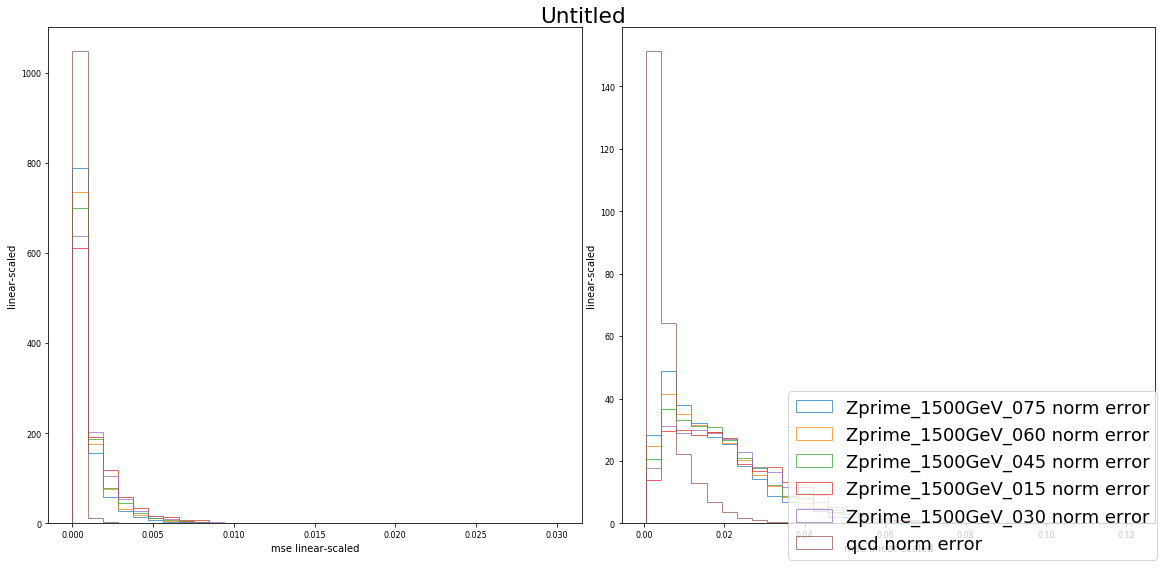

In [145]:
err[0].plot(err[1:], normed=1)

In [110]:
ae = a.instance.load_model()

train_shell :: using saved model


In [114]:
normed

{'Zprime_1500GeV_015':              Eta       Phi        Pt         M  ChargedFraction       PTD  \
 4302    0.518686  0.012630  0.251935  0.057896         0.234118  0.380440   
 4303    0.373122  0.520933  0.226759  0.039977         0.527619  0.394275   
 26518   0.861395  0.881540  0.296333  0.160106         0.326857  0.132742   
 26519   0.828141  0.969025  0.055048  0.030569         0.395897  0.131772   
 70398   0.577245  0.390209  0.583998  0.096887         0.332308  0.673452   
 70399   0.819384  0.823278  0.080088  0.028905         0.335714  0.393188   
 13944   0.746450  0.063005  0.332376  0.192437         0.567442  0.398196   
 13945   0.502430  0.579107  0.054719  0.026544         0.586667  0.225409   
 70524   0.668341  0.312381  0.279145  0.052955         0.485854  0.129982   
 70525   0.495032  0.800736  0.083802  0.097783         0.640000  0.203350   
 75362   0.232808  0.984680  0.611266  0.039350         0.219259  0.388611   
 75363   0.424171  0.482324  0.156641  0.0

In [115]:
utils.get_recon_errors(normed.values(), ae)

([             mse       mae
  4302    0.000014  0.002813
  4303    0.000021  0.003546
  26518   0.000138  0.008844
  26519   0.000263  0.012569
  70398   0.000040  0.004597
  70399   0.000047  0.006019
  13944   0.000021  0.003553
  13945   0.000270  0.011673
  70524   0.000229  0.011245
  70525   0.000051  0.005213
  75362   0.000396  0.016122
  75363   0.000017  0.002884
  87368   0.000038  0.005181
  87369   0.000019  0.003357
  5022    0.000053  0.005350
  5023    0.000009  0.002050
  48344   0.000003  0.001290
  48345   0.000054  0.005549
  76210   0.000025  0.003234
  76211   0.000033  0.004109
  20816   0.000031  0.004064
  20817   0.000254  0.010993
  12514   0.000221  0.011843
  12515   0.000009  0.002399
  29732   0.000028  0.004066
  29733   0.000069  0.006686
  22888   0.000064  0.005768
  22889   0.000014  0.002676
  13590   0.000037  0.004539
  13591   0.000015  0.002539
  ...          ...       ...
  99782   0.000005  0.001638
  99783   0.000082  0.006816
  7360    0.00

In [50]:
getattr(getattr(d, 'qcd')

In [69]:
%run autoencode/module/autoencodeSVJ/evaluate.py
import  glob
eflow_base = 3

d = data_holder(
    qcd='data/background/base_3/*.h5',
    **{os.path.basename(p): '{}/base_{}/*.h5'.format(p, eflow_base) for p in glob.glob('data/all_signals/*') if p.split('/')[-1].startswith('1500')}
)
d.load()

found 6 datasets


In [28]:
e = ev.ae_evaluation(name=elt)

found 1 matches with search '/afs/cern.ch/work/l/llepotti/private/CMS/CMSSW_8_0_20/src/autoencodeSVJ/autoencode/data/summary/hlf_eflow3_7_v159.summary'
train_shell :: using saved model


In [24]:
%run autoencode/module/autoencodeSVJ/evaluate.py

def load_for_training(train_path, test_path, signal_path):
    
    train = signal_element(train_path, 'train')
    train._load()
    
    test = data_holder(
        test=test_path,
        signal=signal_path
    )
    test.load()
    
    return train, test
    
train, test = load_for_training(
    'data/background/base_3/QCD_train.h5',
    'data/background/base_3/QCD_test.h5',
    'data/all_signals/1500GeV_0.15/base_3/*.h5'
)



found 2 datasets


In [6]:
%run autoencode/module/autoencodeSVJ/evaluate.py

import glob

def ae_load(name):
    sd = utils.load_summary(utils.summary_by_name(name))
    
    (eflow,
     hlf,
     hlf_to_drop,
     eflow_base,
     seed,
     qcd_path,
     test_split) = [sd[k] for k in ['eflow', 'hlf', 'hlf_to_drop', 'eflow_base', 'seed', 'qcd_path', 'test_split']]

    d = data_holder(
        QCD=qcd_path,
        **{os.path.basename(p): '{}/base_{}/*.h5'.format(p, eflow_base) for p in glob.glob('data/all_signals/*') if p.split('/')[-1].startswith('1500')}
    )
    
    d.load()
    
    return d

import time

t0 = time.time()
d = ae_load('hlf_eflow3_7_v159')
print time.time() - t0

t0 = time.time()
e = ev.ae_evaluation(name='hlf_eflow3_7_v159')
print time.time() - t0

found 1 matches with search '/afs/cern.ch/work/l/llepotti/private/CMS/CMSSW_8_0_20/src/autoencodeSVJ/autoencode/data/summary/hlf_eflow3_7_v159.summary'
found 6 datasets
2.47959303856
found 1 matches with search '/afs/cern.ch/work/l/llepotti/private/CMS/CMSSW_8_0_20/src/autoencodeSVJ/autoencode/data/summary/hlf_eflow3_7_v159.summary'
train_shell :: using saved model
5.6034090519


In [ ]:
d = 

In [53]:
import h5py

d = utils.data_loader(name='QCD')


for s in glob.glob('data/background/base_3/*.h5'):
    d.add_sample(s)b


data_loader :: Adding sample at path '/afs/cern.ch/work/l/llepotti/private/CMS/CMSSW_8_0_20/src/autoencodeSVJ/data/background/base_3/data_0_data.h5'
data_loader :: Adding sample at path '/afs/cern.ch/work/l/llepotti/private/CMS/CMSSW_8_0_20/src/autoencodeSVJ/data/background/base_3/data_6_data.h5'
data_loader :: Adding sample at path '/afs/cern.ch/work/l/llepotti/private/CMS/CMSSW_8_0_20/src/autoencodeSVJ/data/background/base_3/data_3_data.h5'
data_loader :: Adding sample at path '/afs/cern.ch/work/l/llepotti/private/CMS/CMSSW_8_0_20/src/autoencodeSVJ/data/background/base_3/data_1_data.h5'
data_loader :: Adding sample at path '/afs/cern.ch/work/l/llepotti/private/CMS/CMSSW_8_0_20/src/autoencodeSVJ/data/background/base_3/data_2_data.h5'
data_loader :: Adding sample at path '/afs/cern.ch/work/l/llepotti/private/CMS/CMSSW_8_0_20/src/autoencodeSVJ/data/background/base_3/data_4_data.h5'
data_loader :: Adding sample at path '/afs/cern.ch/work/l/llepotti/private/CMS/CMSSW_8_0_20/src/autoencode

In [60]:
files[0]['jet_features']

[u'data', u'labels']

In [11]:
d.add_attribute(name='norm', function=lambda self: self.data.norm(d.QCD))

AttributeError: 'signal_element' object has no attribute 'norm'

data_table :: plotting distrubution(s) for table(s) ['Zprime_1500GeV_075 event features', 'Zprime_1500GeV_060 event features', 'Zprime_1500GeV_045 event features', 'Zprime_1500GeV_015 event features', 'Zprime_1500GeV_030 event features', 'QCD event features']


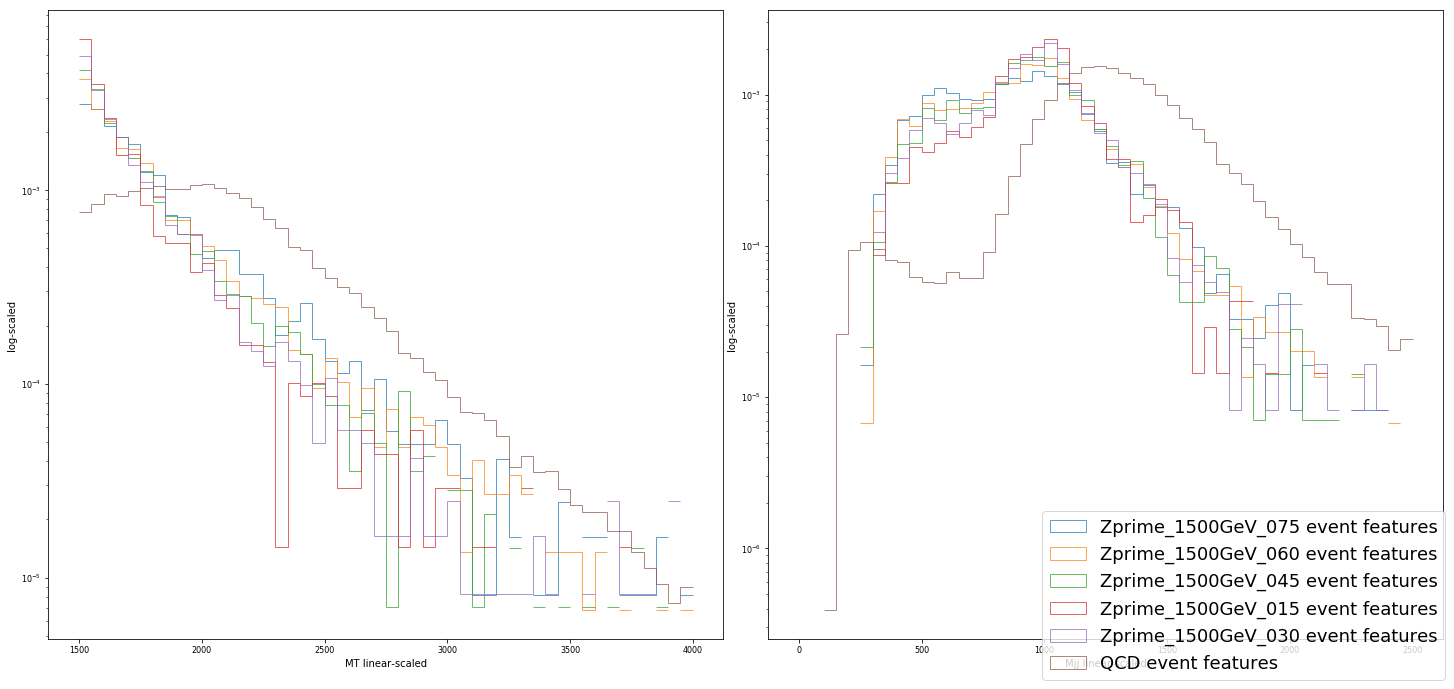

In [4]:
key = 'event'

data = map(lambda x: x.cfilter(['MT', 'Mjj']), d.get(key))

data[0].plot(
    data[1:], normed=1, yscale='log', cols=2, 
    bins=50, figloc='lower right', figname='', 
    rng=((data[0].MT.min(), 4000),(0,2500)), figsize=(20,10)
)



In [11]:
import glob
import matplotlib.pyplot as plt
import matplotlib
%matplotlib inline
import numpy as np
matplotlib.rcParams.update({'font.size': 16})
from collections import OrderedDict as odict

plt.rc('text', usetex=True)
plt.rc('font', family='serif')

def plotdata(elt_dicts, filter=["*"], drop=[], names="*"):
    if isinstance(elt_dicts, odict):
        elt_dicts = {'NONE': elt_dicts}
    
    modified = {}
    elt_dict = {}
    for k,v in elt_dicts.items():
        d = v.copy()
        for sub_k in v:
            if k == 'NONE':
                key = sub_k
                d[key] = v[sub_k]
            else:
                key = (sub_k + ' ' + k).strip()
                d[key] = v[sub_k]
                del d[sub_k]
                if sub_k not in modified:
                    modified[sub_k] = []
                modified[sub_k].append(key)

        elt_dict.update(d)
        
    names = utils.parse_globlist(match_list=elt_dict.keys(), glob_list=names)
    
    for name in names.copy():
        if name in modified:
            for subn in modified[name]:
                names.add(subn)
    
    nameset = names.copy()
    names = []
    
    for elt in order:
        add = [] 
        for name in nameset:
            if name.startswith(elt):
                add.append(name)
        names += sorted(add)

    keep = {}
    
    for name in names:
        keep[name] = elt_dict[name].cdrop(drop).cfilter(filter)
    
    
    assert len(keep) > 0
    ref = keep.values()[0]
    cols = []
    
    for c in ref.columns:
        if all([c in v for v in keep.values()]):
            cols.append(c)
#     cols = set.intersection(*[set(v.columns) for v in keep.values()])
    
    ret = odict()
    for c in list(cols):
        ret[c] = odict()
        for name in names:
            ret[c][name] = keep[name][c]
        
    return ret


#     plt.legend(fontsize=20)   
styles = {
    'SVJ': {
        'facecolor': 'm',
        'histtype': 'step',
        'fill': True,
        'edgecolor': 'k',
        'label': r'SVJ',
        'alpha': 0.4,
#         'hatch': '/'
    },
    'qcd': {
        'facecolor': 'y',
        'histtype': 'step',
        'fill': True,
        'edgecolor': 'k',
        'label': r'QCD',
        'alpha': 0.4

    },
    'ttbar': {
        'facecolor': 'C0',
        'label': r'$t\bar{t}$',
        'edgecolor': 'w',
        'hatch': '//',
        'fill': True,
        'histtype': 'step',
        'alpha': 0.4

    }
}

order = [
    'ttbar',
    'SVJ',
    'qcd'
]


var_styles = {
    'ChargedFraction': {
        'xlabel': r'Charged Fraction',
        'fontsize': 20,
    },
    'Pt': {
        'xlabel': r'$\displaystyle p_{T}$',
        'fontsize': 20,
    },
    'Eta': {
        'xlabel': r'$\displaystyle \eta$',
        'fontsize': 20,
#         'range': (0., 0.7),
    },
    'Phi': {
        'xlabel': r'$\displaystyle \phi$',
        'fontsize': 20,
#         'range': (0., 0.7),
    },
    'M': {
        'xlabel': 'Mass',
        'fontsize': 20,
    },
    'mae': {
        'xlabel': 'Reconstruction Error (MAE)',
        'fontsize': 30,
    },
    'PTD': {
        'xlabel': 'PTD',
        'fontsize': 20,
    },
    'Axis2': {
        'xlabel': 'Axis_2',
        'fontsize': 20,
    }
}

# more than needed
for i in range(100):
    var_styles['eflow {}'.format(i)] = {}
    var_styles['eflow {}'.format(i)]['xlabel'] = "Variable {}".format(i)
    var_styles['eflow {}'.format(i)]['fontsize'] = 20
    

In [23]:
m1 = 20./4.
m2 = 14./3.

In [19]:
def pre_eflow(e, bins=50, names="*", ylabel=None, replc='eflow', normed=1, xlog=False, ylog=False, pileup=False):
    data = plotdata(e.dists_dict, filter='eflow *', names=names)
    # print data

    
    fs = 12
    plt.rcParams['font.family'] = 'serif'
    plt.rcParams['figure.autolayout'] = True
    plt.rcParams['xtick.labelsize']=fs
    plt.rcParams['ytick.labelsize']=fs
    matplotlib.rcParams.update({'font.size': 18})
    
    rows, cols = (3,4)
    f, axs = plt.subplots(rows, cols, figsize=(cols*m1, rows*m2))
    axs = axs.flatten()
#     f.suptitle("EnergyFlow Polynomial Distributions", y=1.02, fontsize=30)
    ogbins = bins
    i = 0
    for d,v in data.items():
        ax = axs[i]
        
        if 'bins' in var_styles[d]:
            bins = var_styles[d].pop('bins')
        else:
            bins = ogbins
            
        if 'range' in var_styles[d]:
            rng = var_styles[d].pop('range')
        else:
            rng = map(lambda f: f(map(f, v.values())), [min, max])
        
        for k,datum in v.items():
            nbins = bins
            if ylog:
                ax.set_yscale('log', nonposy='clip')
            if ylabel is not None:
                ax.set_ylabel(ylabel)
            
            if pileup:
                datum[datum < rng[0]] = rng[0]
                datum[datum > rng[1]] = rng[1]
            
            if xlog:
                nbins = np.geomspace(rng[0], rng[1], bins)
                
            ax.hist(datum, range=rng, bins=nbins, normed=normed, **styles[k])
            ax.set_xlabel(**var_styles[d])
#             ax.set_yscale('log')
            if xlog:
                ax.set_xscale('log')
        i += 1
    
    plt.legend(fontsize=20)


In [20]:
def pre_hlf(e, bins=50, names="*", ylabel=None, normed=1, xlog=False, ylog=False, pileup=False):
    data = plotdata(e.dists_dict, drop='eflow *', names=names)
    # print data

    
    fs = 12
    plt.rcParams['font.family'] = 'serif'
    plt.rcParams['figure.autolayout'] = True
    plt.rcParams['xtick.labelsize']=fs
    plt.rcParams['ytick.labelsize']=fs
    matplotlib.rcParams.update({'font.size': 18})
    
    rows, cols = (2,3)
    f, axs = plt.subplots(rows, cols, figsize=(cols*m1, rows*m2))
    axs = axs.flatten()
    f.suptitle("High-Level-Feature Distributions", y=1.02, fontsize=30)
    ogbins = bins
    i = 0
    for d,v in data.items():
        if 'bins' in var_styles[d]:
            bins = var_styles[d].pop('bins')
        else:
            bins = ogbins
            
        if 'range' in var_styles[d]:
            rng = var_styles[d].pop('range')
        else:
            rng = map(lambda f: f(map(f, v.values())), [min, max])
        ax = axs[i]
        for k in v.keys():
            datum = v[k]
            if pileup:
                datum[datum < rng[0]] = rng[0]
                datum[datum > rng[1]] = rng[1]
            nbins = bins
            if xlog:
                nbins = np.geomspace(rng[0], rng[1], bins)
                
            ax.hist(datum, range=rng, bins=nbins, normed=normed, **styles[k])
            ax.set_xlabel(**(var_styles[d]))
#             ax.set_yscale('log')
            if xlog:
                ax.set_xscale('log')
            if ylog:
                ax.set_yscale('log', nonposy='clip')
            if ylabel is not None:
                ax.set_ylabel(ylabel)
            
        i += 1
    
    handles,labels = ax.get_legend_handles_labels()
    plt.figlegend(handles, labels, loc=(.7,.3), fontsize=30)
    for x in axs[i:]:
        f.delaxes(x)
    
#     plt.legend(fontsize=20)


In [21]:
def post_all(e, bins=50, names="*", ylabel=None, normed=1, xlog=False, ylog=False, pileup=False):
    recon_kwd = '(pred)'
    dists = e.dists_dict.copy()
    dists['qcd'] = e.test
    data = plotdata({recon_kwd : e.recons_dict, 'NONE': dists}, names=names)

    fs = 12
    plt.rcParams['font.family'] = 'serif'
    plt.rcParams['figure.autolayout'] = True
    plt.rcParams['xtick.labelsize']=fs
    plt.rcParams['ytick.labelsize']=fs
    matplotlib.rcParams.update({'font.size': 18})
    
    rows, cols = (5,5)
    f, axs = plt.subplots(rows, cols, figsize=(cols*m1, rows*m2))
    axs = axs.flatten()
    f.suptitle("Feature Reconstructions", y=1.02, fontsize=30)
    ogbins = bins
    i = 0
    for d,v in data.items():
        if 'bins' in var_styles[d]:
            bins = var_styles[d].pop('bins')
        else:
            bins = ogbins
            
        if 'range' in var_styles[d]:
            rng = var_styles[d].pop('range')
        else:
            rng = map(lambda f: f(map(f, v.values())), [min, max])
        ax = axs[i]
        
#         keys = reversed(sorted([k for k in v.keys() if len(k.split()) == 1]) + sorted([k for k in v.keys() if len(k.split()) > 1]))
        for k in v.keys():
            
            datum = v[k]
            recon = False
            kp = k 
            if recon_kwd in k:
                recon = True 
                
                kp = k.replace(recon_kwd, '').strip()
            
            if pileup:
                datum[datum < rng[0]] = rng[0]
                datum[datum > rng[1]] = rng[1]
            nbins = bins
            if xlog:
                nbins = np.geomspace(rng[0], rng[1], bins)
                
            style = styles[kp].copy()

#             style['alpha'] = 0.3
            if recon:
                hist,bins = np.histogram(datum, range=rng, bins=nbins, normed=normed)

                style['color'] = style['facecolor']
                style['linewidth'] = 2
                style['label'] = style['label'] + ', (pred)'
                for var in ['histtype', 'fill', 'facecolor', 'edgecolor', 'hatch', 'alpha']:
                    if var in style:
                        style.pop(var)
                
                ax.plot(bins[:-1] + np.diff(bins)/2., hist, marker='+', alpha=1, **style)
#                 ax.scatter(bins[:-1] + np.diff(bins)/2., hist, marker='+', edgecolor='k', **style)
            else:
                ax.hist(datum, range=rng,bins=nbins, normed=normed, **style)
            
            var_style = var_styles[d].copy()
            if 'Variable' in var_style['xlabel']:
                var_style['xlabel'] = "EFP " + var_style['xlabel'] 
                
            ax.set_xlabel(**(var_style))
#             ax.set_yscale('log')
            if xlog:
                ax.set_xscale('log')
            if ylog:
                ax.set_yscale('log', nonposy='clip')
            if ylabel is not None:
                ax.set_ylabel(ylabel)
            
        i += 1
    
    handles,labels = ax.get_legend_handles_labels()
    plt.figlegend(handles, labels, loc=(.802,.12), fontsize=40)
    for x in axs[i:]:
        f.delaxes(x)
    

def pre_all(e, bins=50, names="*", ylabel=None, normed=1, xlog=False, ylog=False, pileup=False):
#     recon_kwd = '(Reconstructed)'
    data = plotdata(e.dists_dict, names=names)

    
    fs = 18
    plt.rcParams['font.family'] = 'serif'
    plt.rcParams['figure.autolayout'] = True
    plt.rcParams['xtick.labelsize']=fs
    plt.rcParams['ytick.labelsize']=fs
    matplotlib.rcParams.update({'font.size': 18})
    
    rows, cols = (5,5)
    f, axs = plt.subplots(rows, cols, figsize=(cols*m1, rows*m2))
    axs = axs.flatten()
#     f.suptitle("Input Variables", y=1.02, fontsize=30)
    ogbins = bins
    i = 0
    for d,v in data.items():
        if 'bins' in var_styles[d]:
            bins = var_styles[d].pop('bins')
        else:
            bins = ogbins
            
        if 'range' in var_styles[d]:
            rng = var_styles[d].pop('range')
        else:
            rng = map(lambda f: f(map(f, v.values())), [min, max])
        ax = axs[i]
        
#         keys = reversed(sorted([k for k in v.keys() if len(k.split()) == 1]) + sorted([k for k in v.keys() if len(k.split()) > 1]))
        for k in v.keys():
            
            datum = v[k]

            if pileup:
                datum[datum < rng[0]] = rng[0]
                datum[datum > rng[1]] = rng[1]
            nbins = bins
            if xlog:
                nbins = np.geomspace(rng[0], rng[1], bins)
                
            style = styles[k].copy()

#             style['alpha'] = 0.3
            ax.hist(datum, range=rng,bins=nbins, normed=normed, **style)
            
            var_style = var_styles[d].copy()
            if 'Variable' in var_style['xlabel']:
                var_style['xlabel'] = "EFP " + var_style['xlabel'] 
                
            ax.set_xlabel(**(var_style))
#             ax.set_yscale('log')
            if xlog:
                ax.set_xscale('log')
            if ylog:
                ax.set_yscale('log', nonposy='clip')
            if ylabel is not None:
                ax.set_ylabel(ylabel)
            
        i += 1
    
    handles,labels = ax.get_legend_handles_labels()
    plt.figlegend(handles, labels, loc=(.82,.165), fontsize=40)
    for x in axs[i:]:
        f.delaxes(x)
    
# pre_all(e, ylog=0, normed=1, pileup=1)

In [64]:
# pre_all(e, normed=1)
# post_all(e, ylog=0, normed=1)

In [65]:
def errors(e, bins=50, names="*", drop='mse', ylabel=None, normed=1, xlog=False, ylog=False, pileup=True, rng=None):
#     recon_kwd = '(Reconstructed)'
    data = plotdata(e.errs_dict, names=names, drop=drop)

    fs = 18
    plt.rcParams['font.family'] = 'serif'
    plt.rcParams['figure.autolayout'] = True
    plt.rcParams['xtick.labelsize']=fs
    plt.rcParams['ytick.labelsize']=fs
    matplotlib.rcParams.update({'font.size': 30})
    
#     rows, cols = (1,1)
    f, ax = plt.subplots(1, 1, figsize=(2*m1, 2*m2))
    
#     f.suptitle("Input Variables", y=1.02, fontsize=30)
    ogbins = bins
    
    for d,v in data.items():
        if 'bins' in var_styles[d]:
            bins = var_styles[d].pop('bins')
        else:
            bins = ogbins
            
        if 'range' in var_styles[d]:
            rng = var_styles[d].pop('range')
        elif rng is None:
            rng = map(lambda f: f(map(f, v.values())), [min, max])
        
        
#         keys = reversed(sorted([k for k in v.keys() if len(k.split()) == 1]) + sorted([k for k in v.keys() if len(k.split()) > 1]))
        for k in v.keys():
            
            datum = v[k]

            if pileup:
                datum[datum < rng[0]] = rng[0]
                datum[datum > rng[1]] = rng[1]
            nbins = bins
            if xlog:
                nbins = np.geomspace(rng[0], rng[1], bins)
                
            style = styles[k].copy()

#             style['alpha'] = 0.3
            ax.hist(datum, range=rng,bins=nbins, normed=normed, **style)
            
            var_style = var_styles[d].copy()
            if 'Variable' in var_style['xlabel']:
                var_style['xlabel'] = "EFP " + var_style['xlabel'] 
                
            ax.set_xlabel(**(var_style))
#             ax.set_yscale('log')
            if xlog:
                ax.set_xscale('log')
            if ylog:
                ax.set_yscale('log', nonposy='clip')
            if ylabel is not None:
                ax.set_ylabel(ylabel)
            
    
    handles,labels = ax.get_legend_handles_labels()
    plt.figlegend(handles, labels, loc=(.7,.80), fontsize=30)




In [67]:
# errors(e, ylog=0, normed=1, bins=100)

(0.001, 1)

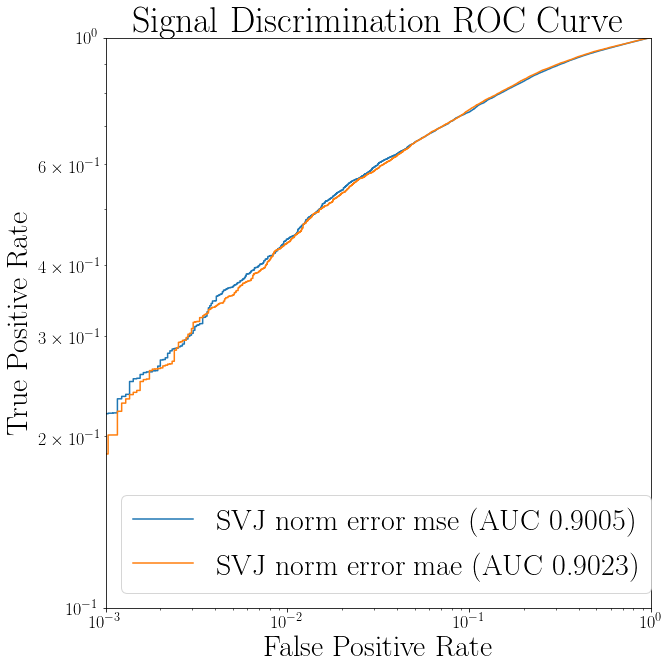

In [70]:
errs = e.roc(figsize=10, yscale='log', xscale='log', figname='SVJ vs. QCD error', fontsize=20, show_plot=0)

plt.figure(figsize=(10,10))
for err in errs:
    for typ in errs[err]:
        roc = errs[err][typ]['roc']
        auc = errs[err][typ]['auc']
        plt.plot(roc[0], roc[1], label='{} {} (AUC {:.4f})'.format(err, typ, auc))

plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Signal Discrimination ROC Curve')
plt.yscale('log')
plt.xscale('log')
plt.legend()
plt.ylim(1e-1, 1)
plt.xlim(1e-3, 1)

In [72]:
# e.error(bins=100, yscale='linear', rng=((0.,0.05), (0.,0.16)))

In [13]:
import glob
import os

from collections import OrderedDict as odict

class data_element:
    def __init__(
        self,
        data,
        names,
        default='data',
    ):
        if not isinstance(names, (list,tuple,dict,set)):
            names = [names]
        if not isinstance(data, (list,tuple,dict,set)):
            data = [data]
            
        assert len(names) == len(data)
        
        self.size = len(names)
        self._obj_dict = odict()
        for name,datum in zip(names,data):
            setattr(self, name, datum)
            self._obj_dict[name] = getattr(self, name)

    def __iter__(
        self
    ):
        return iter(self._obj_dict)
            
    def __len__(
        self,
    ):
        return self.size
    

class data_handler:
    def __init__(
        self,
        hlf=True,
        eflow=True,
        hlf_to_drop=['Flavor', 'Energy'],
        **data_paths
    ):
        
        self._paths = set()
        self._names = set()
        for name,path in data_paths.items():
            self.add_path(name, path, hlf, eflow, hlf_to_drop)
            
    def add_path(
        self,
        name,
        path,
        hlf=1,
        eflow=1,
        hlf_to_drop=['Flavor', 'Energy']
    ):
        assert name not in self._names, "name '{}' is already in this object!! choose another".format(name)
        
        path = os.path.abspath(path)
        if not path.endswith('.h5'):
            path = os.path.join(path, '*.h5')
        
        assert path not in self._paths, "duplicate path being added! '{}' already in filelist".format(path)
        
        ret = utils.load_all_data(
            globstring=path,
            name=name, 
            include_hlf=hlf, 
            include_eflow=eflow,
            hlf_to_drop=hlf_to_drop,
        )
        
        elt = data_element(
            list(ret) + [utils.jet_flavor_split(to_split=ret[0], ref=ret[3])],
            ['data', 'jets', 'event', 'flavor', 'byflavor']
        )
        
        setattr(self, name + "_raw", ret)
        
        setattr(self, name, elt)
        
        self._paths.add(path)
        self._names.add(name)
        
        
#         setattr(self, name, ret[0])
#         setattr(self, name + "_jets", ret[1])
#         setattr(self, name + "_event", ret[2])
#         setattr(self, name + "_flavor", ret[3])


In [14]:
data = data_handler(
#     ttbar="data/ttbar_200pt/base_4/",
    qcd="data/background/base_4/",
    svj_old="data/signal/base_4/",
    svj_norad="data/signal_NoRadNoNu/base_4/",
    hlf_to_drop=['Energy', 'Flavor', 'Axis2', 'PTD']
)

In [29]:
for i in range(len(e.recons)):
    old = e.recons[i].name
    print(old)
    e.recons[i].name = e.recons[i].name.split('inv_normed')[0].strip().strip('\'')

'SVJ norm pred'
'qcd test norm pred'


data_table :: plotting distrubution(s) for table(s) ['SVJ norm error', 'qcd test norm error']


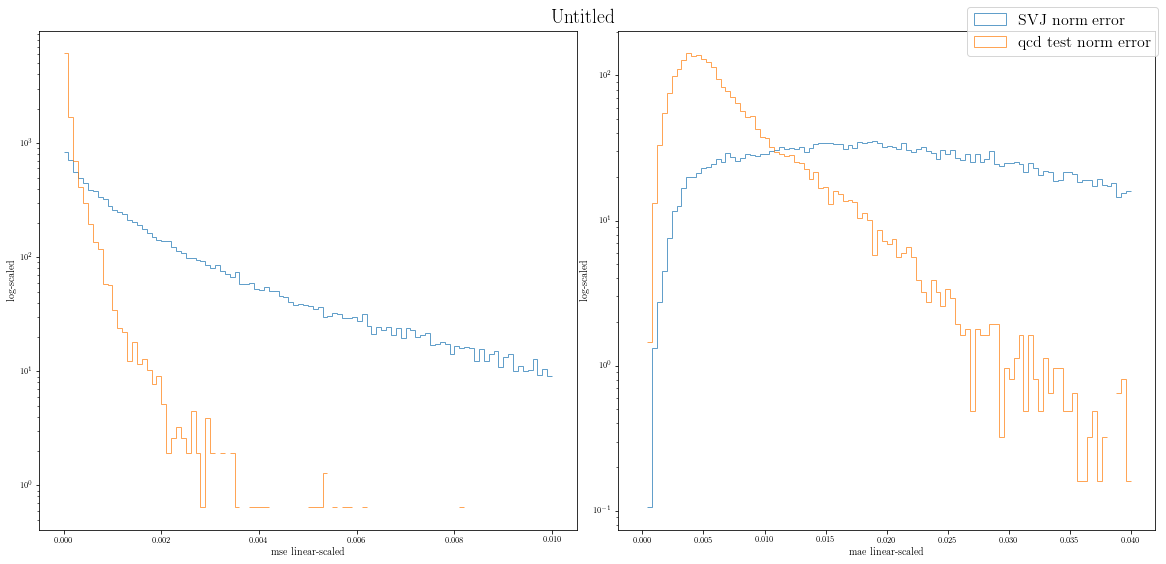

In [63]:
e.errs[0].plot(e.errs[1:], normed=1, yscale='log', bins=100, rng=((0, 0.01), (0, 0.04)), figloc='upper right')